In [2]:
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize

import pandas as pd
import geopandas as geopd

import numpy as np
import numpy.ma as ma

from tqdm.notebook import tqdm

import os
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [3]:
max_seg_length = 4000

src_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/modified_network_{max_seg_length}.gpkg"
dst_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_{max_seg_length}.gpkg"
vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"

land_cover_paths = {2000: "/home/iiro/Documents/GIS-sync/perusdata/syke/corine/clc2000_fi25m/Clc2000_main_classes_hydro.tif", 
                    2006: "/home/iiro/Documents/GIS-sync/perusdata/syke/corine/clc2006_fi25m/Clc2006_main_classes_hydro.tif",
                    2012: "/home/iiro/Documents/GIS-sync/perusdata/syke/corine/clc2012_fi20m/Clc2012_main_classes_hydro.tif",
                    2018: "/home/iiro/Documents/GIS-sync/perusdata/syke/corine/clc2018_fi20m/Clc2018_main_classes_hydro.tif"
                   }

watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

lc_classes = {1 : "urban", 2 : "agriculture", 3 : "forest", 4 : "peatland", 5: "water"}

# Land cover

In [4]:

def add_lc_to_subwatersheds(subwatersheds, land_cover_path, lc_classes, year, bounds):
    """
    Adds land cover classification proportions of a spesific year to subwatersheds.

    Parameters:
    subwatersheds (GeoDataFrame): A GeoDataFrame containing subwatershed geometries and attributes.
    land_cover_path (str): Path to the land cover raster file.
    lc_classes (dict): A dictionary mapping land cover class values to their names.
    year (int): The year of the land cover data.
    bounds (tuple): A tuple containing the bounding box coordinates (minx, miny, maxx, maxy).

    Returns:
    GeoDataFrame: The input GeoDataFrame with additional columns for each land cover class proportion.
    """
    place_id = subwatersheds.at[0, 'Paikka_Id']
    
    minx, miny, maxx, maxy = bounds
    # TODO functionize and repeat for all the land covers classifications    
    with rasterio.open(land_cover_path) as src:
        profile = src.profile
        values = src.read(
            1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
            boundless=True, fill_value=profile['nodata'])
    
    profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
    profile['width'] = values.shape[1]
    profile['height'] = values.shape[0]
    # For visualization
    #masked_values = ma.masked_values(values, profile['nodata'])
    
    for key in lc_classes:
        class_name = lc_classes[key]
        class_values = np.where(values == key, 1, 0)

        for j, subwatershed in subwatersheds.iterrows():

            subwatershed = geopd.GeoDataFrame(
                    dict(zip(list(subwatershed.index), list(subwatershed.values))),
                    crs=subwatersheds.crs, geometry='geometry', index=[0])
            area_mask = rasterize(
                    subwatershed['geometry'], (profile['height'], profile['width']),
                    dtype=profile['dtype'], transform=profile['transform'], all_touched=True)
    
            area = area_mask.sum()
            
            clipped_values = np.where(area_mask == class_values, class_values, 0)
    
            class_area = clipped_values.sum()

            # Some subwaterhseds cause minor problems 
            warnings.filterwarnings("error")
            
            try:
                class_portion = class_area / area

            except:
                class_portion = 0
                print(f"{class_name}_portion was set to zero for watershed {place_id}, subwatershed {j} because {class_area} or {area} were invalid features")
            warnings.filterwarnings("default")
            
            
            subwatersheds.at[j, f"{class_name}_portion_{year}"] = class_portion

    return subwatersheds

In [5]:
test_selection = 30

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    #if i < test_selection:
        #continue

    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])

    place_id = watershed.at[0, 'Paikka_Id']

    subwatersheds = geopd.read_file(src_path, layer=f"subwatersheds_{place_id}")

    minx = watershed.bounds.at[0, 'minx']
    miny = watershed.bounds.at[0, 'miny']
    maxx = watershed.bounds.at[0, 'maxx']
    maxy = watershed.bounds.at[0, 'maxy']

    for year in land_cover_paths:
        pbar.set_description(f" Doing land cover of {year} for catchment {i}")
        land_cover_path = land_cover_paths[year]
        subwatersheds = add_lc_to_subwatersheds(subwatersheds, land_cover_path, lc_classes, year, (minx, miny, maxx, maxy))

    subwatersheds.to_file(dst_path, layer=f"subwatersheds_{place_id}", driver="GPKG")
    #if i == test_selection:
        #break

  0%|          | 0/142 [00:00<?, ?it/s]

In [17]:
subwatersheds

,Paikka_Id,main_basin_index,area_m2,id,pituus_m,next,pour,dam,in_connect,lake,...,urban_portion_2012,agriculture_portion_2012,forest_portion_2012,peatland_portion_2012,water_portion_2012,urban_portion_2018,agriculture_portion_2018,forest_portion_2018,peatland_portion_2018,water_portion_2018
0,1117,15,4938400.0,8,507.992178,440,False,False,0,False,...,0.071367,0.212284,0.645930,0.061025,0.0,0.071682,0.228389,0.634089,0.033394,0.001500
1,1117,15,1545400.0,440,504.263528,442,False,False,1,False,...,0.176110,0.253127,0.543537,0.000981,0.0,0.171450,0.248958,0.543292,0.000000,0.000736
2,1117,15,747300.0,442,504.401821,444,False,False,1,False,...,0.202935,0.464069,0.325911,0.000000,0.0,0.234312,0.429656,0.328947,0.000000,0.000000
3,1117,15,1663200.0,430,536.981043,432,False,False,1,False,...,0.021111,0.521570,0.453190,0.000000,0.0,0.021111,0.530060,0.443093,0.000000,0.000000
4,1117,15,2351600.0,428,472.993076,430,False,False,0,False,...,0.030667,0.431121,0.504300,0.032452,0.0,0.030991,0.426253,0.523446,0.017848,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,1117,15,655200.0,514,561.501809,516,False,False,1,False,...,0.536059,0.069847,0.348666,0.000000,0.0,0.546848,0.068711,0.286201,0.000000,0.000000
489,1117,15,1944100.0,520,496.362766,522,False,False,1,False,...,0.607866,0.014946,0.377188,0.000000,0.0,0.678466,0.005113,0.306785,0.000000,0.000000
490,1117,15,3701100.0,512,481.872360,514,False,False,1,False,...,0.505410,0.030899,0.455888,0.002081,0.0,0.522264,0.017998,0.445173,0.001769,0.000000
491,1117,15,1062500.0,516,514.730314,518,False,False,1,False,...,0.336068,0.027114,0.613271,0.000000,0.0,0.377453,0.007492,0.566536,0.000000,0.000000


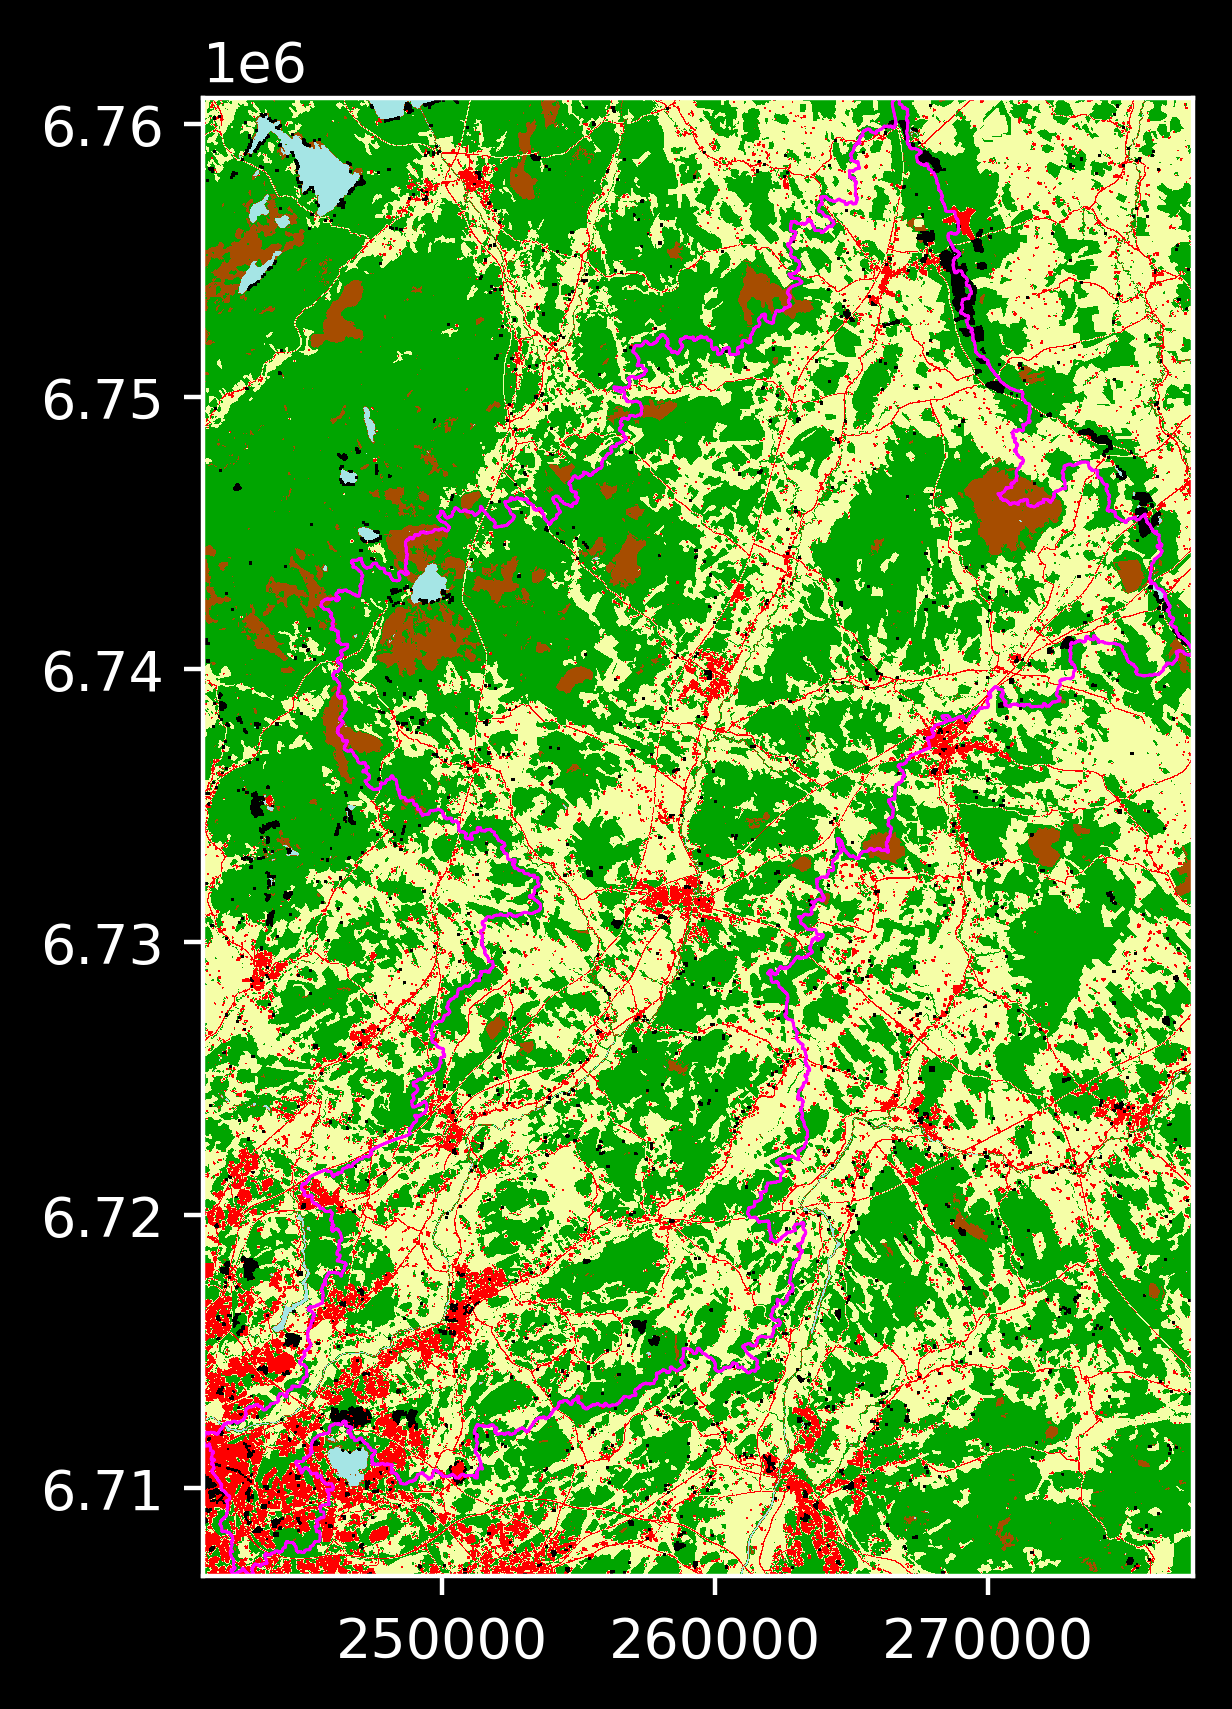

In [20]:

cmap = ListedColormap(["#fe0000", "#f5fea7", "#00a500", "#a64d00", "#a5e5e5"])

fig, ax = plt.subplots()
show(masked_values, transform=profile['transform'], ax=ax, cmap=cmap)
#show(class_values, transform=profile['transform'], ax=ax, interpolation='none', cmap='cividis')
#show(clipped_values, transform=profile['transform'], ax=ax, interpolation='none', cmap='cividis')
ax = watershed.boundary.plot(ax=ax, color='fuchsia', linewidth=0.5)



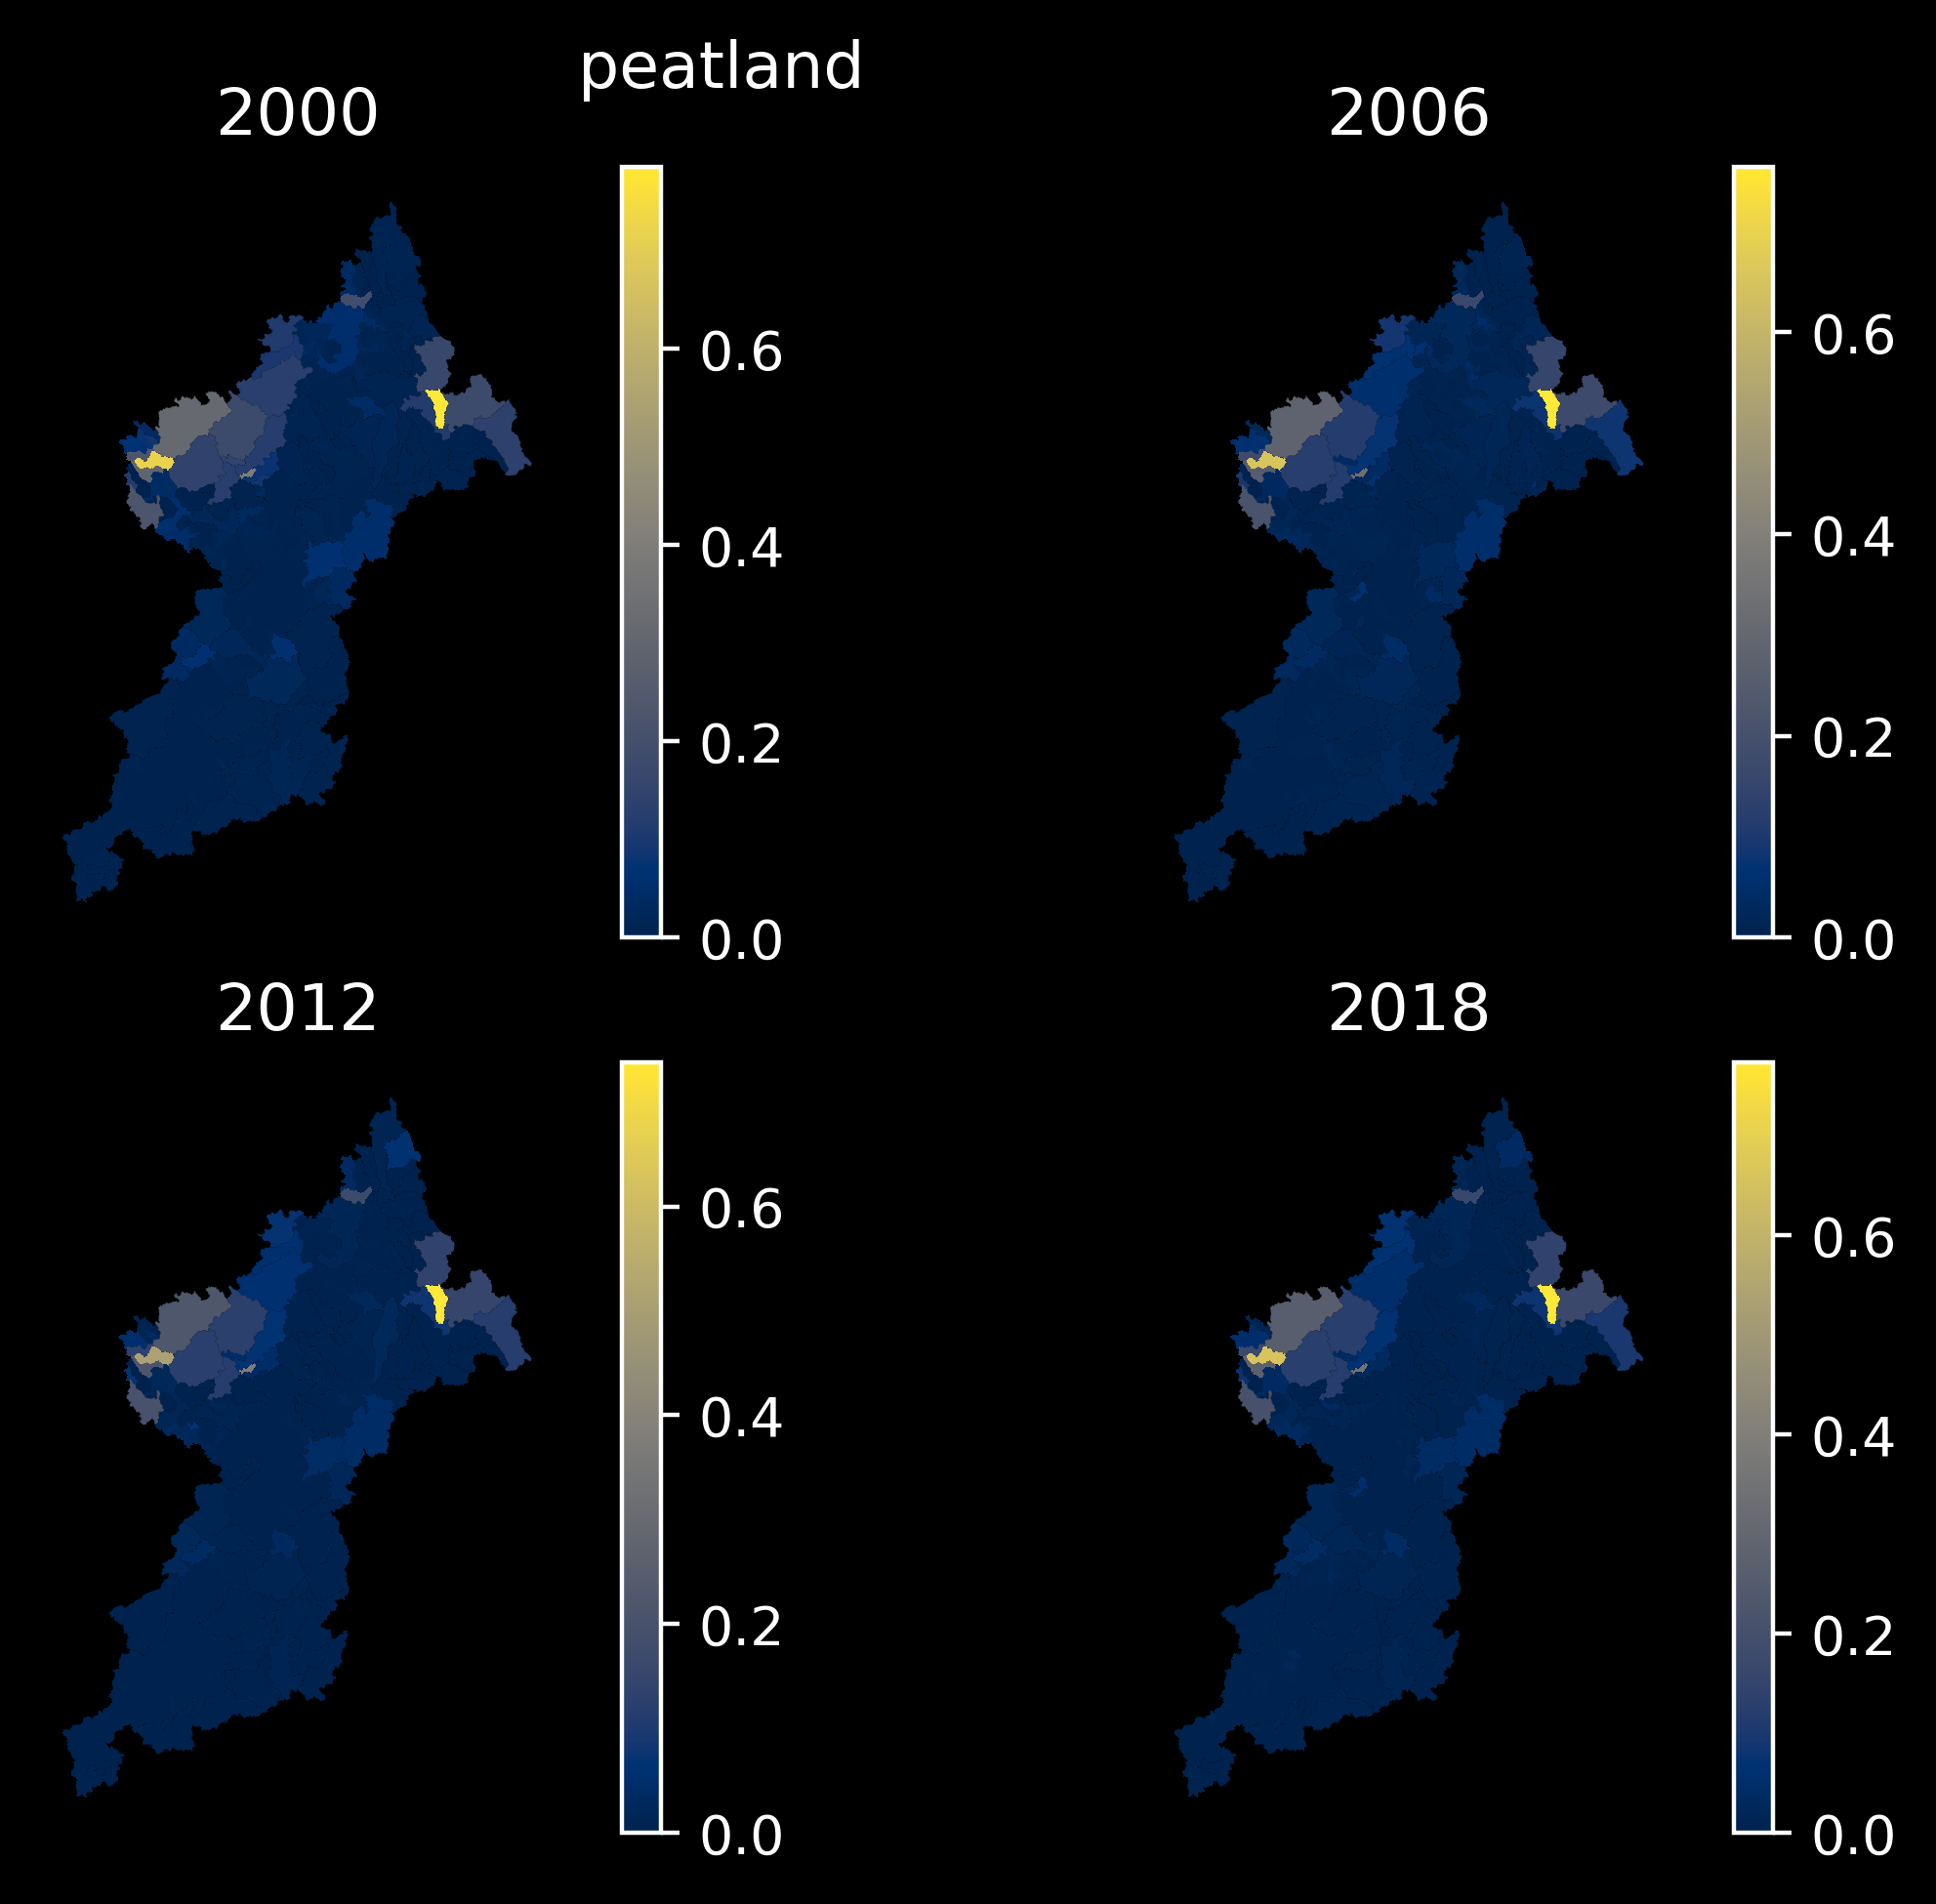

In [40]:
fig, axs = plt.subplots(2, 2)
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
lc_class = "peatland"
fig.suptitle(lc_class)
ax1 = subwatersheds.plot(f"{lc_class}_portion_2000",ax=ax1, markersize=0.2, cmap='cividis', legend=True)
ax1.set_axis_off()
ax1.set_title(2000)

ax2 = subwatersheds.plot(f"{lc_class}_portion_2006", ax=ax2, markersize=0.2, cmap='cividis', legend=True)
ax2.set_axis_off()
ax2.set_title(2006)

ax3 = subwatersheds.plot(f"{lc_class}_portion_2012", ax=ax3, markersize=0.2, cmap='cividis', legend=True)
ax3.set_axis_off()
ax3.set_title(2012)

ax4 = subwatersheds.plot(f"{lc_class}_portion_2018", ax=ax4, markersize=0.2, cmap='cividis', legend=True)
ax4.set_axis_off()
ax4.set_title(2018)

plt.tight_layout(pad=0.2)

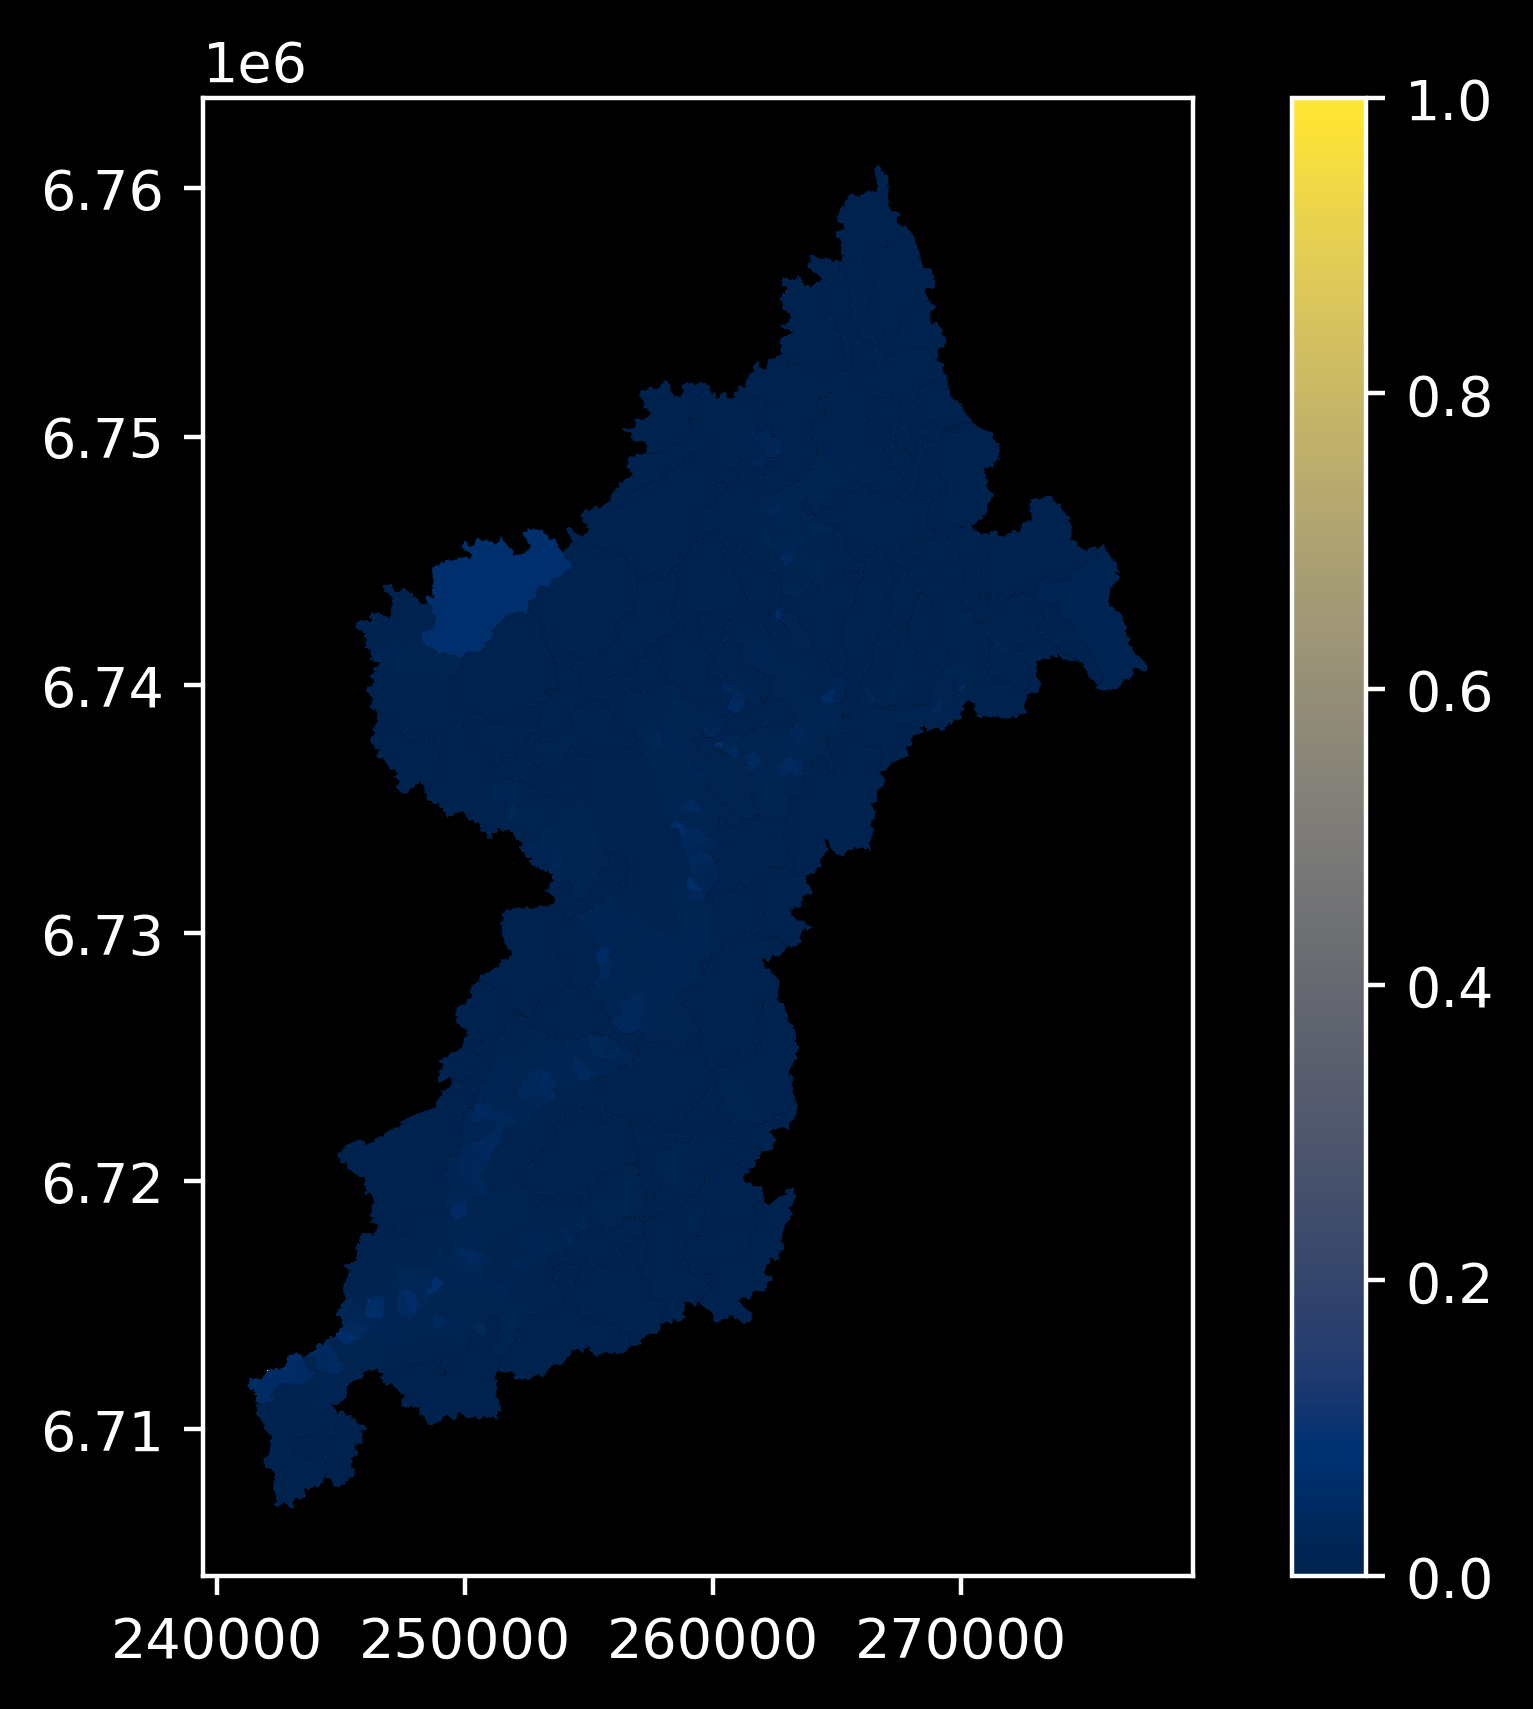

In [38]:
ax = subwatersheds.plot("water_portion", markersize=0.2, cmap='cividis', legend=True)
ax = subwatersheds.loc[[82]].plot(ax=ax, linewidth=10, color="red")

In [6]:
subwatersheds

,Paikka_Id,main_basin_index,area_m2,id,pituus_m,next,pour,dam,in_connect,lake,geometry
0,1117,15,4938400.0,8,507.992178,440,False,False,0,False,"POLYGON ((267820 6758350, 267820 6758320, 2677..."
1,1117,15,1545400.0,440,504.263528,442,False,False,1,False,"POLYGON ((268240 6756290, 268240 6756280, 2682..."
2,1117,15,747300.0,442,504.401821,444,False,False,1,False,"POLYGON ((266430 6755070, 266430 6755040, 2664..."
3,1117,15,1663200.0,430,536.981043,432,False,False,1,False,"POLYGON ((264150 6756250, 264150 6756240, 2641..."
4,1117,15,2351600.0,428,472.993076,430,False,False,0,False,"POLYGON ((263400 6756500, 263400 6756490, 2633..."
...,...,...,...,...,...,...,...,...,...,...,...
488,1117,15,655200.0,514,561.501809,516,False,False,1,False,"POLYGON ((244230 6709040, 244230 6709030, 2442..."
489,1117,15,1944100.0,520,496.362766,522,False,False,1,False,"POLYGON ((241880 6711070, 241880 6711060, 2418..."
490,1117,15,3701100.0,512,481.872360,514,False,False,1,False,"POLYGON ((244980 6710760, 244980 6710750, 2449..."
491,1117,15,1062500.0,516,514.730314,518,False,False,1,False,"POLYGON ((243120 6708740, 243120 6708730, 2431..."


In [34]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 35989, 'height': 61978, 'count': 1, 'crs': CRS.from_epsg(3067), 'transform': Affine(20.0, 0.0, 20000.0,
       0.0, -20.0, 7836760.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

<Axes: >

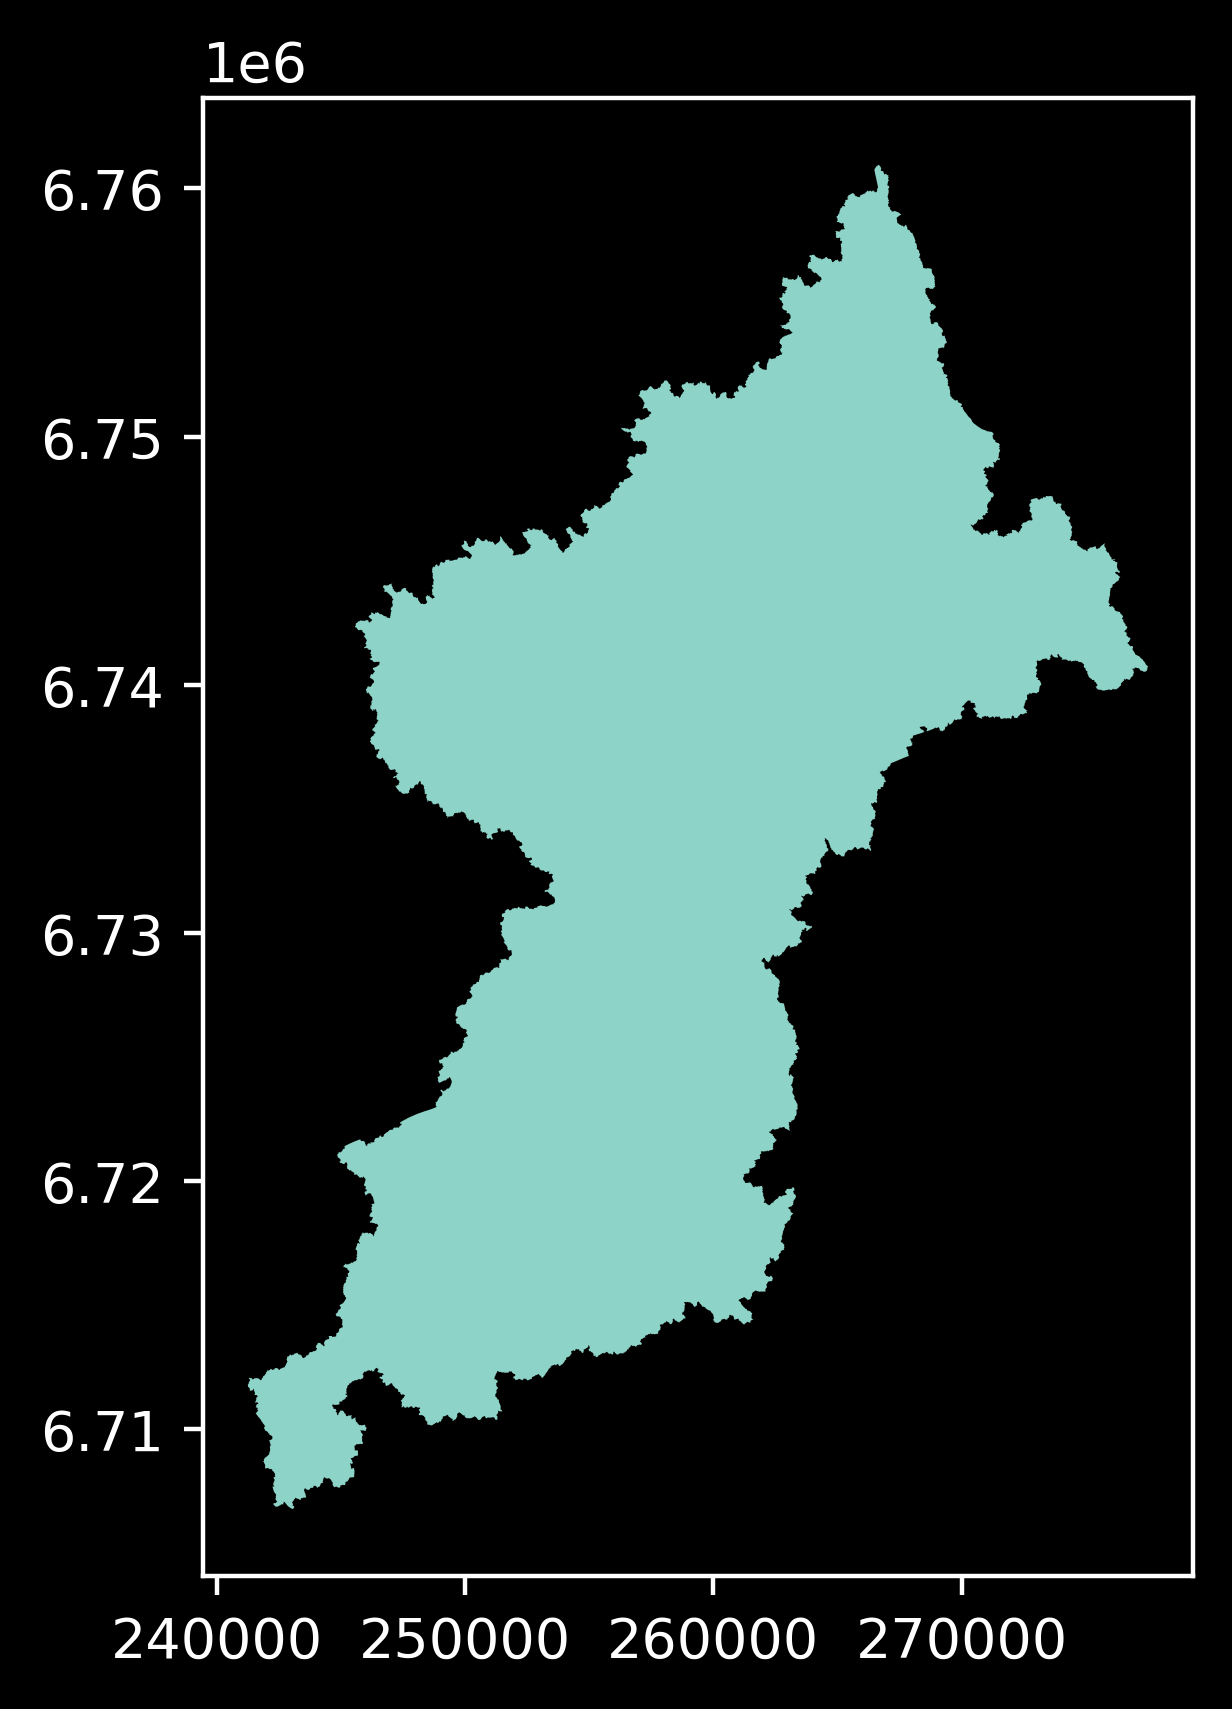

In [35]:
watershed.plot()